In [15]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from locationHelper import LocationHelper
from preProcessingHelper import PreProcessRatings

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tims analysis: is there a change in the reviews based on the season?

In [17]:
# load dataset and store it for faster use
# we do the analysis for BeerAdvocate

pp = PreProcessRatings(platform="BeerAdvocate")
ratings_df = pp.get_dataframe(dataset="ratings", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year"])
ratings_df.to_csv("data/tims_data/beerAdvocateRatings.csv", index=False)

start parsing the beer reviews for BeerAdvocate
finished parsing the beer reviews for BeerAdvocate
start converting datatypes
end converting datatypes
now you can get dataframes with the "get_dataframe" handle
Country svalbard and jan mayen islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country aotearoa could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country fiji islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country heard and mcdonald islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country south georgia and south sandwich islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
From 8393032 reviews, 7892754 have a location (corresponding to the user) and 500278 do not have a location


In [18]:
ratings_df = pd.read_csv("data/tims_data/beerAdvocateRatings.csv")

## ratings over the season?

Text(0.5, 1.0, 'Avg rating over the period 1996 - 2017 with 95% confidence interval, n=8393032')

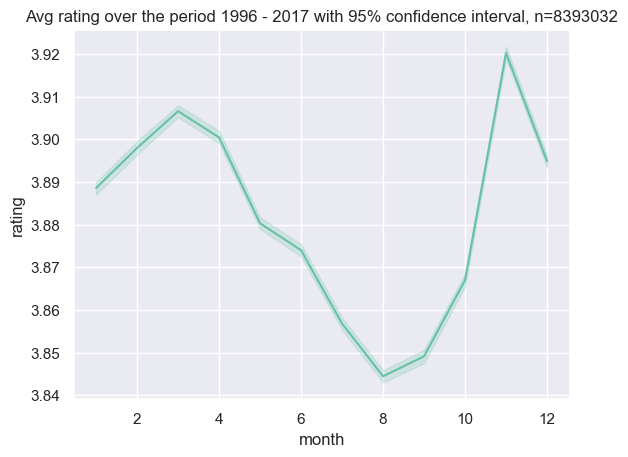

In [20]:
sns.lineplot(ratings_df, x="month", y="rating", estimator="mean", errorbar=("ci", 95))
plt.title(f'Avg rating over the period {ratings_df["year"].min()} - {ratings_df["year"].max()} with 95% confidence interval, n={ratings_df.shape[0]}')

It looks as if the world doesn't rate the beers the same over the year! Why could that be the case?

### Is this trend the same for every year?
We divide the time span into 5 different eras to plot them.

In [33]:
n_groups = 5
min_year, max_year = ratings_df["year"].min(), ratings_df["year"].max()
while (max_year - min_year + 1) % n_groups != 0:
    max_year += 1
all_years = np.arange(min_year, max_year+1)
group_size = np.floor(len(all_years) / n_groups)
year_groups = np.split(all_years, group_size)

for yg in year_groups:
    indices = ratings_df[ratings_df["year"].isin(yg)].index
    ratings_df.loc[indices, "year_group"] = f'{yg.min()}-{yg.max()}'


Text(0.5, 1.0, 'Avg rating over the ears with 95% confidence interval')

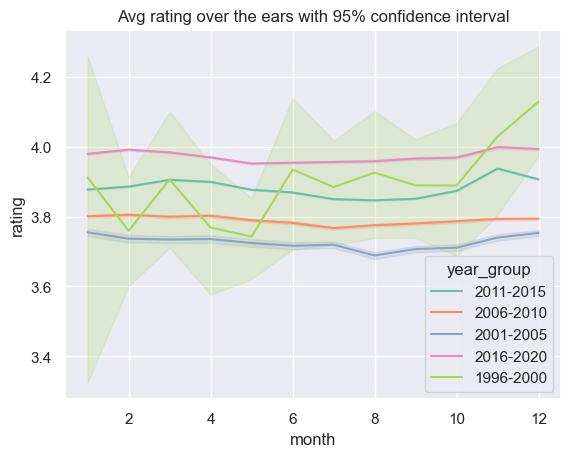

In [60]:
g = sns.lineplot(ratings_df, x="month", y="rating", hue="year_group", estimator="mean", errorbar=("ci", 95))
legend = [yg.get_text() + f', n={ratings_df[ratings_df["year_group"] == yg.get_text()].shape[0]}' for yg in g.get_legend().texts]
plt.title(f'Avg rating over the ears with 95% confidence interval')

In [62]:
print("nr of samples per group: \n", legend)

nr of samples per group: 
 ['2011-2015, n=5896568', '2006-2010, n=944035', '2001-2005, n=215467', '2016-2020, n=1336634', '1996-2000, n=328']


Can we measure if it's the same distribution over every year? -> some kind of statistical test
We assume the that monthly ratings across years follows a normal distribution and variances are similar, therefore we can use ANOVA to test the relationship between the years.

How does it look in the US, where we have the most data? (the amplitude for the countries on the northern hemisphere must be decreased by the ratings of the southern hemisphere.)

Text(0.5, 1.0, 'Avg rating in the US over the period 1996 - 2017 with 95% confidence interval, n=7303870')

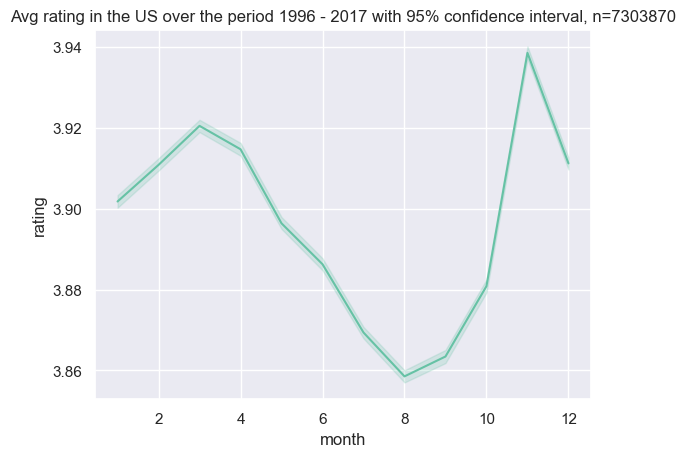

In [65]:
ratings_df_usa = ratings_df[ratings_df["country_code3"] == "USA"]
sns.lineplot(ratings_df_usa, x="month", y="rating", estimator="mean", errorbar=("ci", 95))
plt.title(f'Avg rating in the US over the period {ratings_df_usa["year"].min()} - {ratings_df_usa["year"].max()} with 95% confidence interval, n={ratings_df_usa.shape[0]}')

## distribution of ratings over the world
where the location of the rating is based on the location of the user

In [13]:
ratings_count = ratings_df.groupby("country_code3").agg(nr_ratings=("country_code3", "count")).reset_index()
ratings_count["nr_ratings_log"] = np.log2(ratings_count["nr_ratings"]).replace(-np.inf, 0)

country_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
map = folium.Map(location=[10, 0], zoom_start=1.5)
cp = folium.Choropleth(geo_data=country_geo,
            data=ratings_count,
            columns=['country_code3', 'nr_ratings_log'],
            key_on='feature.id',
            fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
            legend_name="Nr. of ratings (log2 scale)",
            highlight=True

        ).add_to(map)

for s in cp.geojson.data['features']:
      if s['id'] in ratings_count['country_code3'].values:
            s['properties']['nr_ratings'] = (ratings_count[ratings_count["country_code3"] == s['id']]["nr_ratings"]).values[0].astype(str)
      else:
            s['properties']['nr_ratings'] = "0"
      
folium.GeoJsonTooltip(['name', "nr_ratings"]).add_to(cp.geojson)
folium.LayerControl().add_to(map)

map

We take countries with a lot of ratings that are locally separated such as:
- United States of America
- Australia
- Germany
- Sweden
- United Kingdom
- Brazil

<Axes: xlabel='month', ylabel='rating'>

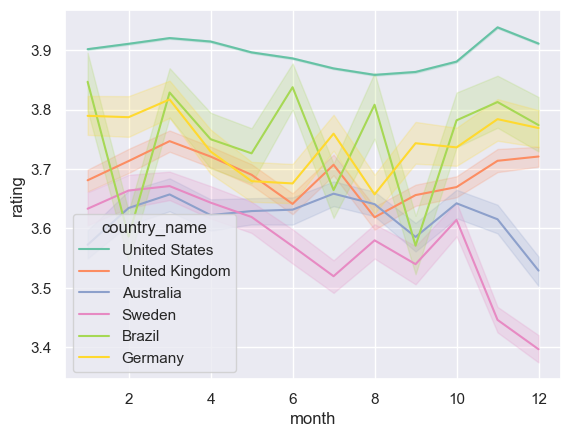

In [22]:
countries_chosen = ["USA", "DEU", "BRA", "GBR", "AUS", "SWE"]
sns.lineplot(ratings_df[ratings_df["country_code3"].isin(countries_chosen)],
             x="month",
             y="rating",
             hue="country_name",
             estimator="mean",
             errorbar=("ci", 95))

Next steps:
- Do statistical test on the countries -> i guess we can't reject nullhypothesis that there is no difference between them.
- Then focus on the US to see why there is such a graph